# Import packages

In [66]:
# !pip install -r multiff_analysis/requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import general_utils, specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from non_behavioral_analysis.neural_data_analysis.model_neural_data.cca_methods import cca_class, cca_utils, cca_plotting, cca_lag_vs_no_lag_plotting, cca_cv_utils, cca_cv_plotting
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class, decode_target_utils
from non_behavioral_analysis.neural_data_analysis.gpfa_methods import elephant_utils, fit_gpfa_utils, gpfa_regression_utils, plot_gpfa_utils

import sys
import math
import gc
import subprocess
from pathlib import Path

# Third-party imports
import numpy as np
from numpy import var
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi
import cProfile
import pstats

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

# To fit gpfa
import numpy as np
from importlib import reload
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from elephant.gpfa import gpfa_core, gpfa_util




plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
#raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0328"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.02, window_width=0.05)

In [3]:
# dec.get_x_and_y_var(exists_ok=True)
# dec.reduce_y_var_lags(exists_ok=True)

In [3]:
dec.streamline_making_behav_and_neural_data(exists_ok=False)
dec.get_x_and_y_var(exists_ok=False)
dec._free_up_memory()
dec.pursuit_data.head(3)

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Bruno/data_0328/ff_dataframe.h5
Retrieved target_df


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/neural_data_analysis/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(


Warnings: At least one ff has a lower bound of ff_angle_boundary equal to its upper bound after clipping, meaning that the ff's angle to boundary is greater than 90 degrees. Please check the input.

NA Values Analysis for behav_data_all (179,921 rows)

Columns with NA values:
------------------------------------------------------------
time_since_target_last_seen                68,775 (  38.2%)
target_last_seen_distance                  68,775 (  38.2%)
time_target_last_seen                      68,775 (  38.2%)
target_last_seen_angle                     68,775 (  38.2%)
target_last_seen_angle_to_boundary         68,775 (  38.2%)
monkey_x_target_last_seen                  68,775 (  38.2%)
monkey_y_target_last_seen                  68,775 (  38.2%)
monkey_angle_target_last_seen              68,775 (  38.2%)
cum_distance_when_target_last_seen         68,775 (  38.2%)
distance_from_monkey_pos_target_last_seen   68,775 (  38.2%)
cum_distance_since_target_last_seen        68,775 (  38.2%)
d

/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Initial subset of columns with VIF > 5
                        feature                vif
32        time_target_last_seen                inf
27  time_since_target_last_seen                inf
35                         time                inf
0                           bin 141546960033.00000
1                   point_index    138195831.60000
42                      segment        20893.30000
36                 cum_distance         4186.00000
39               gaze_world_x_r          110.90000
41                     target_x           88.10000
37               gaze_world_x_l           59.60000
40               gaze_world_y_r           35.70000
9     monkey_y_target_last_seen           32.70000
14            gaze_mky_view_y_r           24.10000
13            gaze_mky_view_x_r           14.30000
38               gaze_world_y_l           10.60000
15        gaze_mky_view_angle_r            9.10000
31      target_opt_arc_dheading            6.00000
17               num_visible_ff            

/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Iter 1: Dropped time_target_last_seen (VIF: inf)
Iter 2: Dropped bin (VIF: 135416060358.4)
Iter 3: Dropped point_index (VIF: 130621397.9)
Iter 4: Dropped cum_distance (VIF: 2664.9)
Iter 5: Dropped segment (VIF: 659.4)
Iter 6: Dropped gaze_world_x_r (VIF: 83.9)
Iter 7: Dropped gaze_world_x_l (VIF: 47.6)
Iter 8: Dropped gaze_world_y_r (VIF: 17.3)
Iter 9: Dropped gaze_mky_view_x_r (VIF: 11.1)
Iter 10: Dropped gaze_mky_view_angle_r (VIF: 6.1)
After iterative dropping, the column with the highest VIF of the dataframe or subset is min_visible_ff_distance with VIF 3.7
Dropped columns:  ['time_target_last_seen' 'bin' 'point_index' 'cum_distance' 'segment'
 'gaze_world_x_r' 'gaze_world_x_l' 'gaze_world_y_r' 'gaze_mky_view_x_r'
 'gaze_mky_view_angle_r']
Kept columns:  ['time_since_target_last_seen' 'time' 'target_x'
 'monkey_y_target_last_seen' 'gaze_mky_view_y_r' 'gaze_world_y_l'
 'target_opt_arc_dheading' 'num_visible_ff' 'min_visible_ff_distance'
 'gaze_mky_view_angle_l']
The shape of the red

,bin,point_index,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,monkey_speeddummy,whether_new_distinct_stop,delta_distance,monkey_x_target_last_seen,monkey_y_target_last_seen,LDy,LDz,RDy,RDz,gaze_mky_view_x_l,gaze_mky_view_y_l,gaze_mky_view_angle_l,gaze_mky_view_x_r,gaze_mky_view_y_r,gaze_mky_view_angle_r,eye_world_speed,valid_view_point_l,valid_view_point_r,...,time_since_target_last_seen,target_last_seen_distance,target_last_seen_angle,target_last_seen_angle_to_boundary,time_since_last_capture,traj_curv,target_opt_arc_dheading,time_target_last_seen,distance_from_monkey_pos_target_last_seen,cum_distance_since_target_last_seen,d_heading_since_target_last_seen,time,monkey_x,monkey_y,cum_distance,gaze_world_x_l,gaze_world_y_l,gaze_world_x_r,gaze_world_y_r,target_index,target_x,target_y,segment,segment_start_dummy,segment_end_dummy
0,1328,1600,1.53938,-0.16494,0.00000,0.00000,6.97237,1.00000,False,0.02538,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,0.01648,95.40816,-0.56230,-0.45730,1.90892,-0.00373,-0.86477,26.55835,0.02538,0.02538,0.00000,26.57483,-348.34170,681.15979,3225.00842,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507,1.00000,0.00000,0.00000
1,1329,1601,20.33766,-0.16494,0.00000,0.00000,12.60664,1.00000,False,0.33667,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,0.03304,95.40816,-0.56230,-0.45730,1.92548,-0.00373,-0.86821,26.55835,0.36205,0.36205,0.00000,26.59139,-348.00931,681.10632,3225.34509,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507,1.00000,0.00000,0.00000
2,1330,1602,26.75265,-0.16494,0.00000,-0.00372,8.00479,1.00000,False,0.44471,-348.36676,681.16382,-77.00000,46.00000,-103.00000,45.00000,5.80012,35.20791,-0.16327,8.39757,37.41921,-0.22076,11.44420,False,False,...,0.04966,95.40816,-0.56230,-0.45730,1.94210,-0.00412,-0.87280,26.55835,0.80676,0.80676,0.00000,26.60801,-347.57025,681.03565,3225.78980,-314.69370,669.67820,-312.93890,666.75291,2,-277.09608,617.73507,1.00000,0.00000,0.00000


In [5]:
dec.x_var_lags.shape

(33125, 243)

In [6]:
dec.y_var_lags.shape

(33125, 673)

# Reduce columns in lags

In [7]:
# dec.reduce_x_var_lags() # this has been shown to not do anything
dec.reduce_y_var_lags()

Loaded y_var_lags_reduced from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/decode_target_y_var_lags_reduced.csv


In [8]:
# # get final vif
# vif_df = drop_high_vif_vars.get_vif_df(dec.y_var_lags_reduced)

# GPFA

## get data for GPFA

In [9]:
dec.prepare_spikes_for_gpfa(align_at_beginning=False)

print(len(dec.spiketrains))
print(len(dec.spiketrains[0]))
print(len(dec.spiketrains[0][2]))

711
22
1


## fit gpfa

In [ ]:
# # manually save the trajectories (this will be done in class henceforward)

# alignment = 'segStart' if dec.align_at_beginning else 'segEnd'
# file_name = f'gpfa_neural_aligned_{alignment}_d{10}.pkl'

# trajectories_path = os.path.join(
#             dec.decoding_targets_folder_path, file_name)

# with open(trajectories_path, 'wb') as f:
#     pickle.dump(dec.trajectories, f)
# print(f'Saved GPFA trajectories to {trajectories_path}')

Saved GPFA trajectories to all_monkey_data/decoding_targets/monkey_Bruno/data_0328/gpfa_neural_aligned_segEnd_d10.pkl


In [10]:
dec.get_gpfa_traj(latent_dimensionality=10)


Loaded GPFA trajectories from all_monkey_data/decoding_targets/monkey_Bruno/data_0328/gpfa_neural_aligned_segEnd_d10.pkl


In [12]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## plot latent dimensions

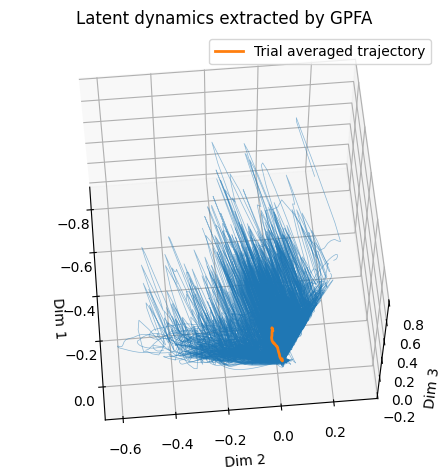

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'Latent dynamics extracted by GPFA'}, xlabel='Dim 1', ylabel='Dim 2', zlabel='Dim 3'>)

In [37]:
plot_gpfa_utils.plot_gpfa_traj_3d_uniform_color(dec.trajectories)


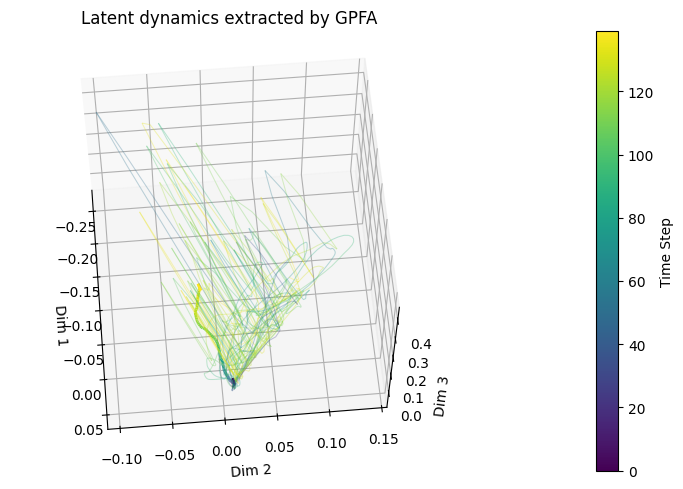

In [26]:
# First, enable interactive mode in your notebook
%matplotlib inline

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create the interactive plot
fig, ax = plot_gpfa_utils.plot_gpfa_traj_3d(
    trajectories=dec.trajectories,
    figsize=(15, 5),
    linewidth_single_trial=0.75,
    alpha_single_trial=0.3,
    linewidth_trial_average=2,
    title='Latent dynamics extracted by GPFA',
    view_azim=-5,
    view_elev=60
)

plt.show()

In [ ]:
# fig = plot_gpfa_utils.plot_gpfa_traj_3d_plotly(trajectories)

In [27]:
# Find variance explained by each latent dimension
traj_stack = np.stack(dec.trajectories, axis=0)  # shape: (n_trials, 3, T)
var_by_dim = var(traj_stack, axis=(0, 2))    # variance across trials and time
var_by_dim /= var_by_dim.sum()               # normalize to get explained variance ratio
print("Variance explained by each latent dimension:", var_by_dim)


Variance explained by each latent dimension: [0.38133 0.28006 0.12792 0.06138 0.0622  0.03551 0.02254 0.0138  0.00877
 0.00649]


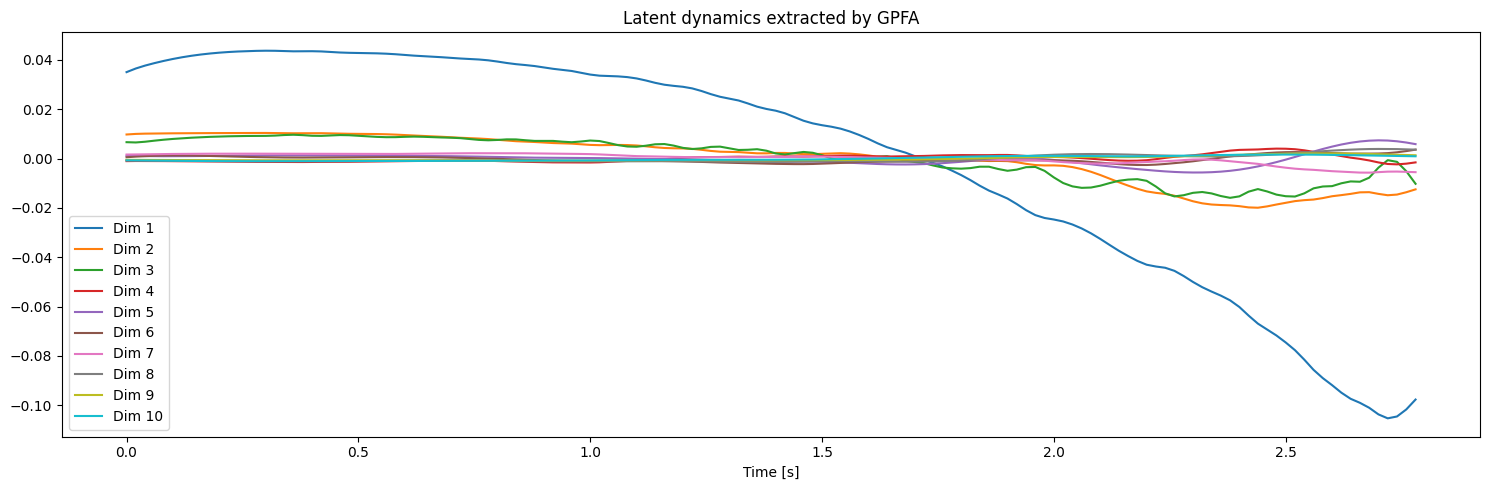

In [38]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Latent dynamics extracted by GPFA')
ax.set_xlabel('Time [s]')

average_trajectory = np.mean(dec.trajectories, axis=0)
time = np.arange(len(average_trajectory[0])) * 0.02  # assuming all trajectories have the same length

for i, x in enumerate(average_trajectory):
    ax.plot(time, x, label=f'Dim {i+1}')

ax.legend()

plt.tight_layout()
plt.show()


## prepare data for regression

## regression

In [ ]:
dec.common_t_stop = max(dec.spike_segs_df['t_duration']) * pq.s + dec.bin_width_w_unit        

In [23]:
dec.get_gpfa_and_behav_data_for_all_trials()

In [24]:
max_timepoints = int(1.5/0.02)
scores_by_time, times = gpfa_regression_utils.run_time_resolved_regression_variable_length_trials(dec.gpfa_trials, dec.behav_trials, time_step=0.02, cv_folds=5, max_timepoints=max_timepoints)

In [17]:
dec.gpfa_y_var.shape

(33125, 36)

In [26]:
scores_by_time_df = pd.DataFrame(scores_by_time, columns=dec.gpfa_y_var_columns)

# check one dummy variable
if 'whether_new_distinct_stop' in dec.gpfa_y_var_columns:
    # see the percentage of 1 of this dummy variable
    dec.gpfa_y_var[['whether_new_distinct_stop']].sum()/len(dec.gpfa_y_var)

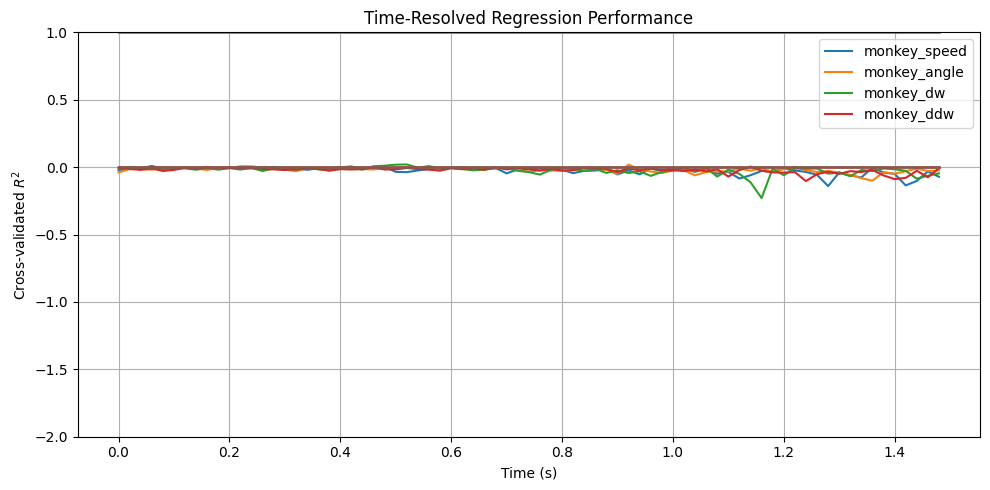

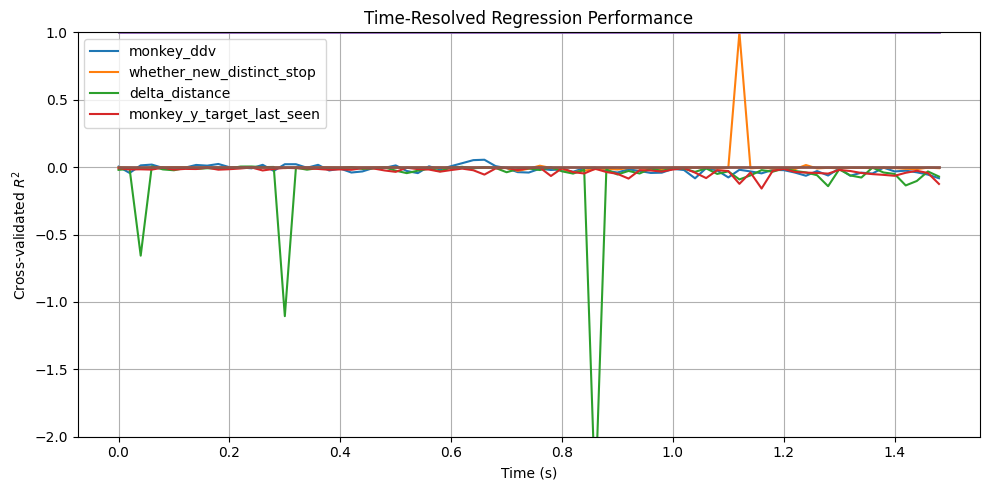

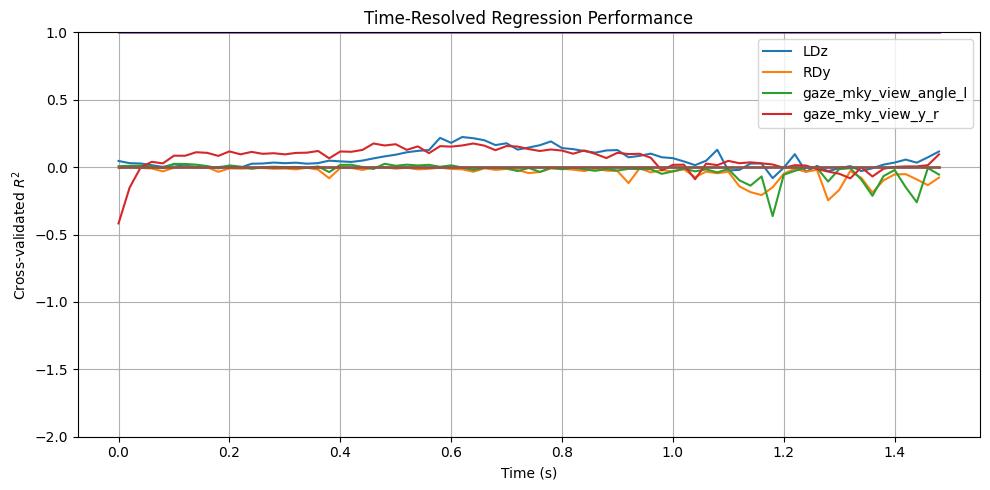

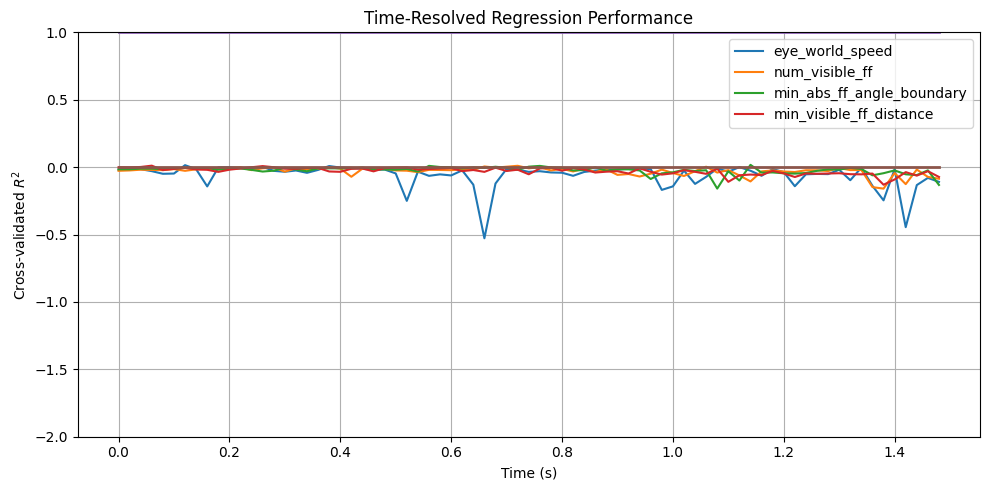

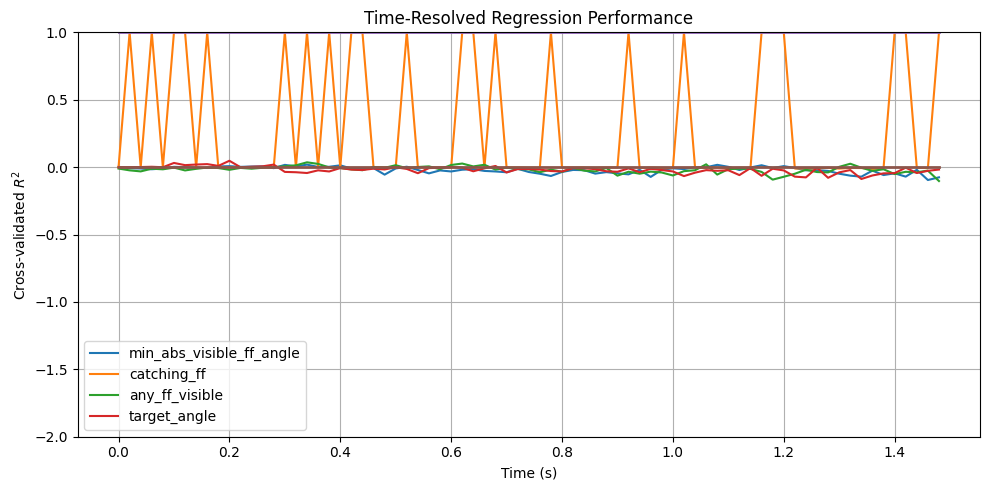

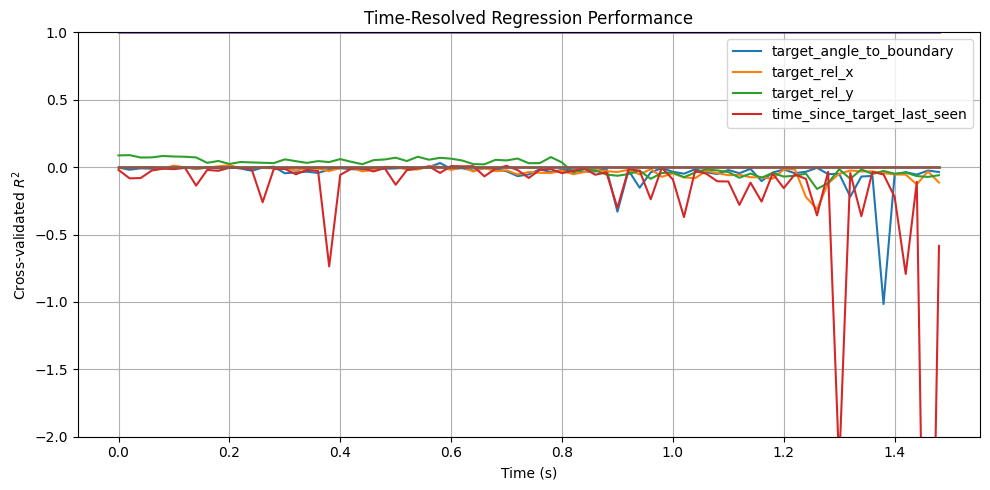

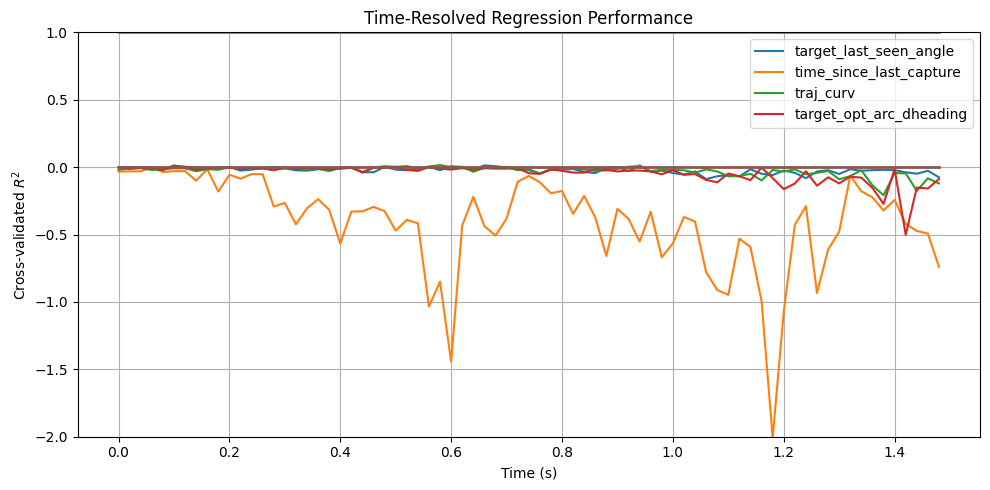

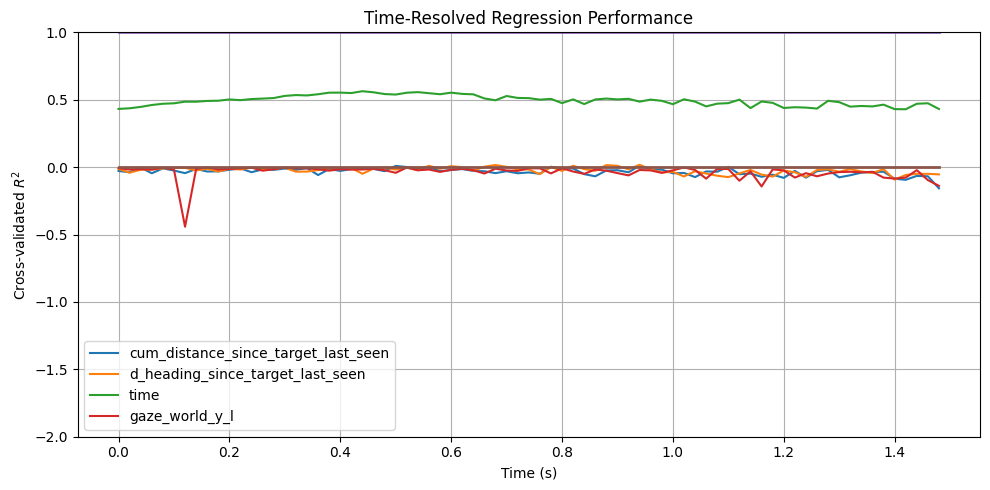

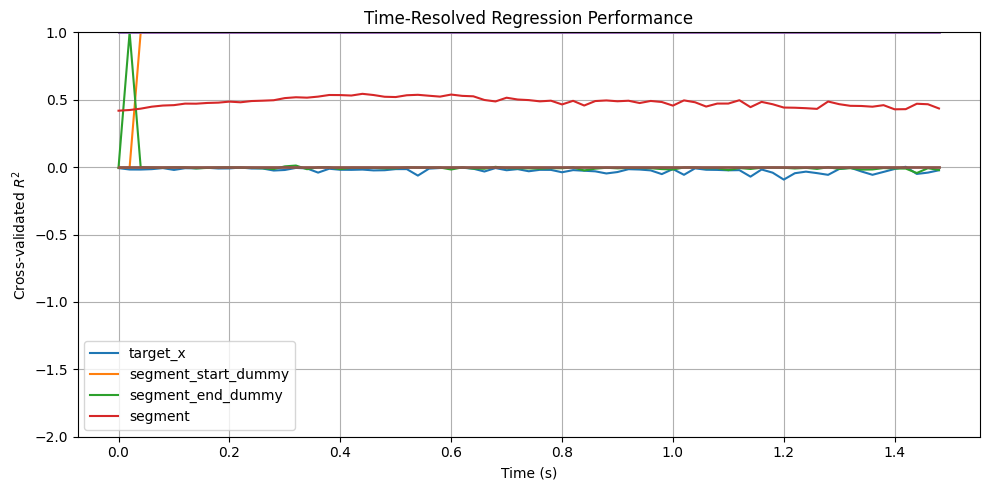

In [28]:
gpfa_regression_utils.plot_time_resolved_scores(scores_by_time, times, behavior_labels=scores_by_time_df.columns)


Text(0, 0.5, 'Trials with data')

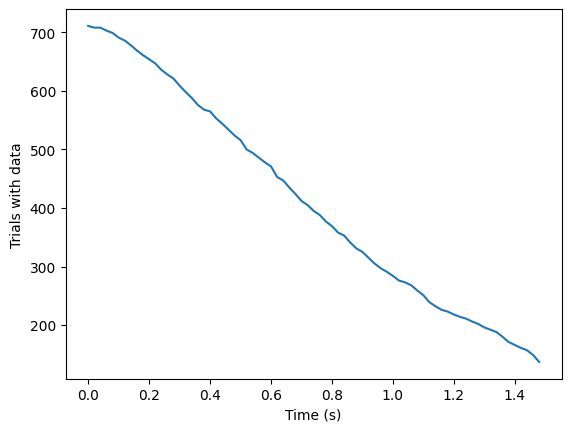

In [30]:
trial_counts = np.array([sum(latent.shape[0] > t for latent in dec.gpfa_trials)
                         for t in range(scores_by_time.shape[0])])
plt.plot(times, trial_counts)
plt.xlabel("Time (s)")
plt.ylabel("Trials with data")


# try ML

In [ ]:
# General usage for any behavioral variable
decoder = ml_decoder_class.MLBehavioralDecoder()

# Decode target variables
results = decoder.decode_variable(neural_data, behavioral_data, 'target_distance')

# Decode movement variables  
results = decoder.decode_variable(neural_data, behavioral_data, 'velocity_x')

# Decode eye position
results = decoder.decode_variable(neural_data, behavioral_data, 'eye_position_x')

# Decode any other behavioral variable
results = decoder.decode_variable(neural_data, behavioral_data, 'attention_level')

# Get best model for any variable
best_model, best_results = decoder.get_best_model('velocity_x', 'test_r2')

# Make predictions for any variable
predictions = decoder.predict_new_data(new_neural_data, 'eye_position_y')

# Plot results for any variable
decoder.plot_ml_results('target_angle', 'rf')

In [ ]:
# This still works exactly as before
decoder = ml_decoder_class.MLBehavioralDecoder()
results = decoder.decode_targets(neural_data, target_data, 'target_distance')

# behav features

In [ ]:
# find set difference between dec.behav_data_all.columns and dec.behav_data.columns
diff_columns = set(dec.behav_data_all.columns) - set(dec.behav_data.columns)

## check result of reducing

In [ ]:
## also check correlations between x vars without lags
high_corr_pair_df, top_n_corr_df = drop_high_corr_vars.get_pairs_of_columns_w_high_corr(
            dec.x_var, corr_threshold=0.8)
top_n_corr_df

# Linear regression (didn't modify yet)
Regressing the behavioral variables individually (as y_var) against all neural activity

## put results in df

In [ ]:
# dec.make_or_retrieve_y_var_lr_resault_df(exists_ok=True)
dec.y_var_lr_result_df = neural_data_modeling.get_y_var_lr_result_df(
                dec.x_var_lags_reduced, dec.y_var)
dec.y_var_lr_result_df.head(5)

##  plot all neural clusters vs one behavioral var

In [ ]:
# drop existing columns involving bin (most likely there's only one or zero after being reduced, because different lags of bins can have very high correlations)
bin_cols = [col for col in dec.y_var_lags_reduced.columns if 'bin' in col]
dec.y_var_lags_reduced.drop(columns=bin_cols, inplace=True)

# then we add the variable bin (so that only the 0 lag is used)
dec.y_var_lags_reduced['bin'] = dec.y_var_lags['bin_0'].astype(int)

In [ ]:


# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = dec.y_var_lags_reduced['bin'].values
for i, column in enumerate(dec.y_var_lags_reduced.columns):

    plot_neural_data.plot_regression(dec.y_var_lags_reduced, column, dec.x_var_lags_reduced, bins_to_plot=bins_to_plot, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

##  plot one neural cluster vs one behavioral var

In [ ]:
# plot one neural cluster against one behavioral variable
cluster_num, behavioral_column = 6, 'monkey_speed'
bins_to_plot = range(1000, 1200)
x_values = dec.binned_spikes_df.loc[bins_to_plot, f'unit_{cluster_num}'].values
y_values = dec.pursuit_data[behavioral_column][bins_to_plot]
reg = LinearRegression().fit(x_values.reshape(-1, 1), y_values)

plt.scatter(x_values, y_values, color='blue', s=1)
plt.plot(x_values, reg.predict(x_values.reshape(-1, 1)), color='red', linewidth=1)
plt.show()

# PGAM (unfinished)

In [ ]:
## Categorize variables
dec.y_var_reduced.columns
temporal_vars = ['time_rel_to_stop',
 'time_when_nxt_ff_first_seen_rel_to_stop',
 'time_when_cur_ff_first_seen_rel_to_stop',
 'time_when_nxt_ff_last_seen_rel_to_stop',
 'time_when_cur_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in dec.y_var_reduced.columns if x not in temporal_vars]
spatial_vars

# Inspect data

## sparsity of neural data

In [ ]:
dec.binned_spikes_df.shape

In [ ]:
# inspect neural data

bins = dec.binned_spikes_df

# Calculate percentage of non-zero rows for each column
non_zero_percentages = (bins != 0).mean() * 100

# Create a DataFrame with the results
non_zero_df = pd.DataFrame({
    'Column': non_zero_percentages.index,
    'Percent_Non_Zero': non_zero_percentages.values
})

# Sort by percentage in descending order
non_zero_df = non_zero_df.sort_values('Percent_Non_Zero', ascending=False)

print("Percentage of non-zero values in each column:")
print(non_zero_df)


In [ ]:
bins.drop(columns='bin').mean(axis=1).describe()

# plot the percentile of values of mean firing rates across neurons at each time bin
mean_rates = bins.drop(columns='bin').mean(axis=1)

# Calculate percentiles from 0 to 100
percentiles = np.arange(0, 101, 1)
percentile_values = np.percentile(mean_rates, percentiles)

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Mean Firing Rate')
plt.title('Distribution of Mean Firing Rates Across Neurons')
plt.grid(True)
plt.show()


## multicollinearity

### y var (behavioral)

In [ ]:
y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

In [ ]:
# Try y_var_reduced

y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var_reduced)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## plot trial segments in pursuit_data

In [ ]:
from visualization.matplotlib_tools import plot_trials,
dec.make_PlotTrials_args()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]                     

max_plot_to_make = 2
plot_counter = 0

for index, row in dec.single_vis_target_df.iloc[2:].iterrows():

    duration = [row['last_vis_time'], row['ff_caught_time']]

    returned_info = plot_trials.PlotTrials(
                duration, 
                *dec.PlotTrials_args,  
                adjust_xy_limits=True,       
                minimal_margin=50,
                show_reward_boundary=True,
                show_alive_fireflies=False,
                show_visible_fireflies=True,
                show_in_memory_fireflies=True,
                show_believed_target_positions=True,
                )
    plt.show()
    

    plot_counter += 1
    if plot_counter >= max_plot_to_make:
        break

### check target_rel_x and y
(The look correct after checking)

In [ ]:
pursuit_sub = dec.pursuit_data.loc[dec.pursuit_data['target_index']==65].copy()
pursuit_sub['target_angle_deg'] = pursuit_sub['target_angle'] * 180/pi 

In [ ]:
pursuit_sub[['point_index', 'target_angle_deg', 'target_distance', 'target_rel_x', 'target_rel_y']]

# Reducing columns in lags: experiment

## check for contributions

In [ ]:
df = dec.y_var_lags_reduced.copy()
# for target_feature in vif_df[vif_df['vif'] > 5].feature.values:
for index, row in vif_df.iterrows():
    target_feature = row.feature
    print(f'\n\n {target_feature}: VIF = {row.vif}')
    contributions = drop_high_vif_vars.check_vif_contribution(df, target_feature)

## check subset's vif

### use y_var_lags

In [ ]:
columns = [col for col in dec.y_var_lags.columns if ('LD' in col) or (
                'RD' in col) or ('gaze_mky_view_angle' in col)]

df_sub = dec.y_var_lags[columns].copy()
print(df_sub.columns)
sub_vif = drop_high_vif_vars.get_vif_df(df_sub)
sub_vif

### use y_var_lags_reduced

In [ ]:
# columns = [col for col in dec.y_var_lags_reduced.columns if ('LD' in col) or (
#                 'RD' in col) or ('gaze_mky_view_angle' in col)]

columns = [col for col in dec.y_var_lags_reduced.columns if ('x_r' in col) or ('y_r' in col)]

df_sub = dec.y_var_lags_reduced[columns].copy()
print(df_sub.columns)
sub_vif = drop_high_vif_vars.get_vif_df(df_sub)
sub_vif

## exp on subsets to reduce

In [ ]:
dec.reduce_y_var_lags(filter_vif_by_feature=False)

In [ ]:
subset_key_words, all_column_subsets = dec.get_subset_key_words_and_all_column_subsets_for_vif(
            dec.y_var_lags_reduced)
subset_key_words

# Appendix

## check NA

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)

# test speed of code

In [ ]:
# Run profiler and save output to file
cProfile.run('dec.streamline_making_behav_and_neural_data()', 'profile_output')

# Load stats and sort by total time
p = pstats.Stats('profile_output')
p.strip_dirs().sort_stats('tottime').print_stats(10)

In [ ]:
p.strip_dirs().sort_stats('tottime').print_stats()

## See sizes of biggest variables

### in dec

In [ ]:
from pympler import asizeof

sizes = []
for attr in dir(dec):
    if attr.startswith('__') and attr.endswith('__'):
        continue  # skip dunder attributes
    try:
        val = getattr(dec, attr)
        size = asizeof.asizeof(val)
        sizes.append((attr, size))
    except Exception:
        pass  # ignore any errors

# Sort and display largest attributes in MB
for name, size in sorted(sizes, key=lambda x: x[1], reverse=True):
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


### global

In [ ]:
import types
import warnings
from pympler import asizeof

warnings.filterwarnings("ignore", category=UserWarning)


filtered = {
    k: v for k, v in globals().items()
    if not isinstance(v, types.ModuleType)
}

sizes = []
for name, val in filtered.items():
    try:
        sizes.append((name, asizeof.asizeof(val)))
    except:
        pass

for name, size in sorted(sizes, key=lambda x: x[1], reverse=True)[:20]:
    print(f"{name}: {size / (1024 * 1024):.2f} MB")


## more columns (possibly get in the future)

get also get: (but to be honest, it doesn't make that much sense to get them....so let's skip for now.)
'distance traversed since target last visible',
'd angle since target last visible', 'target_at_right',
'time_till_capture', 'time from last visible to capture

Note that there might be multicollinearity. For example, duration from last visible to capture = time since target last visible + time till capture

Similarly, target angle = target angle last seen frozen - d angle since target last visible

(For distance it's not exactly the same because of the difference between distance and distance traversed, but it's still similar)

The multicollinearity is fine in linear regression (when each feature here is a y var), but need to be dealt with in cca.

## other thoughts

should i actually align each section, as if they are trials???
maybe i can try both that and continuous time... both can shed light on different behavioral variables
but for aligning trials, it may require alignment or warping since trial durations vary.

btw, what does it mean stitch data?

also, what does it look like to use RNN to model it?
I thought about the paper that Noah presented on


btw.......IME

## why ratio of bin/target_index approaches constant

In [ ]:
trial_lengths = dec.pursuit_data[['target_index', 'bin']].groupby('target_index').count()
trial_lengths.describe()

In [ ]:
sub = dec.y_var_reduced[['time', 'bin', 'target_index']]
sub['factor'] = dec.y_var_reduced['bin']/dec.y_var_reduced['target_index']
sub

In [ ]:
plt.hist(np.diff(dec.ff_caught_T_sorted), bins=30)
plt.xlabel('Time difference')
plt.ylabel('Count')
plt.title('Distribution of time differences between caught events')
plt.show()


In [ ]:
dec.ff_caught_T_sorted/np.arange(len(dec.ff_caught_T_sorted))

## compared with neural_data_modeling

In [ ]:
dec = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
dec.streamline_preparing_neural_and_behavioral_data()

In [ ]:
dec.final_behavioral_data

In [ ]:
dec.y_var

In [ ]:
dec.y_var_reduced

In [ ]:
dec.y_var.columns

In [ ]:
dec.y_var_reduced.columns

In [ ]:
[col for col in dec.y_var.columns if col not in dec.y_var_reduced.columns]

In [ ]:
[col for col in dec.y_var_reduced.columns if col not in dec.y_var.columns]

## Check gpfa's binned spikes vs my own binned spikes

In [ ]:
spike_segs_df = fit_gpfa_utils.make_spike_segs_df(dec.spike_df, dec.single_vis_target_df)


### get binned spikes (seqs) from gpfa_utils.

In [ ]:
seg_index = 9
cluster_index = 12
seg = dec.spiketrain_corr_segs[seg_index]
cluster = dec.spike_segs_df.cluster.unique()[cluster_index]

spiketrain = dec.spiketrains[seg_index][cluster_index]
seqs = gpfa_util.get_seqs([spiketrain], dec.bin_width_w_unit)

### take out my own binned spikes

In [ ]:
p_sub = dec.pursuit_data_all[dec.pursuit_data_all['segment']==seg]
binned_spikes_sub = dec.binned_spikes_df[dec.binned_spikes_df['bin'].isin(p_sub['bin'])].copy()
binned_spikes_sub['bin'] = binned_spikes_sub.index
binned_spikes_sub2 = binned_spikes_sub.merge(p_sub[['bin', 'time']], on='bin', how='left')
binned_spikes_sub3 = binned_spikes_sub2[['bin', 'time', f'unit_{cluster}']].copy()

### compare

In [ ]:
trial_length = len(binned_spikes_sub3)
if dec.align_at_beginning:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][trial_length:]
else:
    binned_spikes_sub3['gpfa'] = seqs[0][1][0][-trial_length:] # when getting latent dimension for neural data, [-trial_length:] was also used
binned_spikes_sub3['same'] = binned_spikes_sub3[f'unit_{cluster}'] == binned_spikes_sub3['gpfa']
binned_spikes_sub3[binned_spikes_sub3['same']!=True]

## find out why there are rows of NA in dec.y_var

In [ ]:
na_rows, na_cols = general_utils.find_rows_with_na(dec.y_var)
duplicate_rows = general_utils.find_duplicate_rows(dec.y_var, column_subset=None)

In [ ]:
dec.behav_data_all.loc[118189:118195, ['bin', 'time', 'target_rel_x', 'target_rel_y','time_since_target_last_seen', 'target_last_seen_distance']]

## Compare old and new target df

In [ ]:
target_df_ori = pd.read_csv('/Users/dusiyi/Documents/Multifirefly-Project/all_monkey_data/patterns_and_features/monkey_Schro/data_0416/target_df_ori.csv')
df = target_df_ori[['target_index', 'point_index', 'time']].copy()
for col in ['target_distance', 'time_since_target_last_seen']:
    df[f'old_{col}'] = target_df_ori[col]   
    df[f'new_{col}'] = dec.target_df[col]  

df['old_target_last_seen_distance'] = target_df_ori['target_last_seen_distance_frozen']
df['new_target_last_seen_distance'] = dec.target_df['target_last_seen_distance']

df2 = df.loc[10068:]
df2

In [ ]:
df3 = df2[df2['point_index']>= 139910]
df3

In [ ]:
139913